# Single Leg Adhesion Grid search


This notebook is to find the maximum adhesion gain necessary for the Drosophila to hold onto the surface with inverted gravity, when adhesion is on only on a single leg. 

In [1]:
"""#installing flygym to use juypternotebook
import os
os.chdir('..')
import sys
path = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder
os.chdir(path)
sys.path.append(path)
"""

"#installing flygym to use juypternotebook\nimport os\nos.chdir('..')\nimport sys\npath = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder\nos.chdir(path)\nsys.path.append(path)\n"

In [2]:
import os
os.getcwd()


'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia\\notebooks'

In [3]:
os.chdir('../')

os.getcwd()

'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia'

In [4]:
"""#installing flygym to use juypternotebook
import os
os.chdir('..')
import sys
path = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder
path = '/Users/lschwitt/flygym_adhesion-Laetitia'
os.chdir(path)
sys.path.append(path)
"""


"#installing flygym to use juypternotebook\nimport os\nos.chdir('..')\nimport sys\npath = '/Users/laeti/Documents/EPFL/BA6Projet/flygym_adhesion-Laetitia'# replace 'my_folder' with the name of your folder\npath = '/Users/lschwitt/flygym_adhesion-Laetitia'\nos.chdir(path)\nsys.path.append(path)\n"

In [5]:
#os.chdir(path)

In [6]:
#os.getcwd()

In [7]:
pip install -e ."[mujoco]

Obtaining file:///C:/Users/lschwitt/flygym_adhesion-Laetitia
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: flygym
    Found existing installation: flygym 0.0.1
    Uninstalling flygym-0.0.1:
      Successfully uninstalled flygym-0.0.1
  Running setup.py develop for flygym
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs
import os 

The gain is the amount of control that is given to a specific actuator. With a gain of 3000 parts were flying away at actuator values 11 i think until 30. I dont think that it is necessary to consider anything outside of that range. That would mean that i would need: 11000 - 33000 max. gain.  

In [9]:
gain_grid = np.linspace(2000, 4000, 2)
#gain_grid = np.array([10000])


In [10]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / 'tripod_engineered.pkl', 'rb') as f:
    data = pickle.load(f)

In [11]:
def run_grid(gain, adhesion_array, render_mode='headless', render_config={}): 
    # Initialize simulation
    run_time = 1
    nmf = NeuroMechFlyMuJoCo(render_mode=render_mode, #no graphic rendering: headless, rendering = 'saved'
                            timestep=1e-4,
                            render_config=render_config, #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                            init_pose='stretch',
                            actuated_joints=all_leg_dofs,
                            adhesion = False,
                            actuators_adhesion_gain =gain,#at 20500 it flies away, at 21000 it stays
                            actuated_bodies='all')
        # Interpolate 5x recording 
    num_steps = int(run_time / nmf.timestep)
    data_block = np.zeros((len(nmf.actuated_joints), num_steps))
    measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
    interp_t = np.arange(num_steps) * nmf.timestep
    for i, joint in enumerate(nmf.actuated_joints):
        data_block[i, :] = np.interp(interp_t, measure_t, data[joint])


    # Run simulation
    obs, info = nmf.reset() 
    #nmf.physics.model.opt.gravity = (0,0,9.81e5)
    old_obs = obs
    obs_list = [obs]
    obs_deriv_touch_sensor_Tarsi5 = []
    for i in trange(num_steps):
        deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
        obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
        
        if i >= int(num_steps/10):
            #inverting gravity midsimulation
            nmf.physics.model.opt.gravity = (0,0,9.81e5)
        
        joint_pos = data_block[:, 0] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_array} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
        old_obs = obs
        obs, info = nmf.step(action)
        
        nmf.render()
        obs_list.append(obs)

    thorax_z_vals = [obs['fly'][0][2] for obs in obs_list] #2 for z-axis

    return nmf, thorax_z_vals

In [12]:
from flygym.util.config import all_adhesion_bodies

In [13]:
all_adhesion_bodies

['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']

In [14]:
legs = ['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']
#legs = ["LF"]

def dichotomous_gain_search(min_gain, max_gain, tol, leg_idx=0, max_height=4000):
    while max_gain - min_gain > tol:
        mid_force = (min_gain + max_gain) // 2
        if run_grid(mid_force, np.where(leg_idx == np.arange(6), 1, 0))[1][-1] > max_height: 
            min_gain = mid_force
        else:
            max_gain = mid_force

    # Refine the search within the tolerance
    found_gains = []
    nmfs = []
    z_vals = []
    for gain in np.linspace(min_gain, max_gain, num=10):
        found_gains.append(gain)
        nmf, thorax_z_vals = run_grid(gain, adhesion_array = np.where(leg_idx == np.arange(6), 1, 0))    
        nmfs.append(nmf)
        z_vals.append(thorax_z_vals)
    did_it_stick = np.where(np.array(z_vals)[:,-1] > 4000, False, True)
    return found_gains, nmfs, z_vals, did_it_stick

def plot_z_vals(z_vals, nmfs, found_gains, leg_idx=0):
    plt.figure(figsize=(10, 6))
    for gain, z_val, nmf in zip(found_gains, z_vals, nmfs):
        plt.plot(np.arange(len(z_val))*nmf.timestep, z_val, label=f'Gain: {gain:.2f}')
    plt.xlabel('Time (s)')
    plt.ylabel('Thorax Z-Position (mm)')
    plt.title(f'Adhesion on {legs[leg_idx]}, gravity inverted at 0.1s')
    plt.legend()
    plt.ylim(750,3000)
    save_path = Path('notebooks/SingleLegFigures',f'Adhesion_on_{legs[leg_idx]}_gravity_inverted_at_01s.png')
    plt.tight_layout()
    fig1 = plt.gcf() 
    plt.show()
    plt.draw()
    fig1.savefig(save_path)





    

In [15]:
found_ranges = []
did_it_stick_ranges = []
z_vals_list = []
nmfs_list = []
for leg_idx in legs:
    found_gains, nmfs, z_vals, did_it_stick = dichotomous_gain_search(1000, 40000, tol = 50, leg_idx=legs.index(leg_idx), max_height=4000)
    found_ranges.append(found_gains)
    nmfs_list.append(nmfs)
    z_vals_list.append(z_vals)
    did_it_stick_ranges.append(did_it_stick)


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1012.65it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1096.64it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1121.57it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1246.48it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2218"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1253.23it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1609"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1609"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1609"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1355.61it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1913"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1372.12it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2065"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1250.02it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1989"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1989"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1989"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1989"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1989"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1989"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1267.31it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1951"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1951"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1951"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1264.07it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1913"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1373.41it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1917.2222222222222"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1917.2222222222222"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1917.2222222222222"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1917.2222222222222"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1917.2222222222222"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1917.2222222222222"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1375.17it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1921.4444444444443"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1921.4444444444443"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1921.4444444444443"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1921.4444444444443"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1921.4444444444443"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1921.4444444444443"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1334.43it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1925.6666666666667"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1925.6666666666667"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1925.6666666666667"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1925.6666666666667"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1925.6666666666667"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1925.6666666666667"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1368.51it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1929.8888888888889"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1255.35it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1934.1111111111111"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1934.1111111111111"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1934.1111111111111"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1934.1111111111111"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1934.1111111111111"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1934.1111111111111"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1378.62it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1938.3333333333333"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1938.3333333333333"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1938.3333333333333"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1938.3333333333333"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1938.3333333333333"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1938.3333333333333"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1248.03it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1942.5555555555557"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1942.5555555555557"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1942.5555555555557"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1942.5555555555557"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1942.5555555555557"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1942.5555555555557"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1261.73it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1946.7777777777778"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1946.7777777777778"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1946.7777777777778"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1946.7777777777778"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1946.7777777777778"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1946.7777777777778"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1277.97it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1951"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1951"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1951"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1951"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1236.87it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1029.13it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1096.10it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1121.84it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1169.28it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2218"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1270.64it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2827"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1176.82it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3132"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3132"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3132"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1193.24it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3284"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3284"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3284"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1120.94it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3360"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1130.80it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3398"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1171.85it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3360"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1168.79it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3364.2222222222222"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1177.69it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3368.4444444444443"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1190.18it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3372.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1161.43it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3376.8888888888887"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1172.43it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3381.1111111111113"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1190.35it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3385.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1174.69it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3389.5555555555557"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1188.45it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3393.7777777777778"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1177.67it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3398"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1158.23it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:10<00:00, 993.32it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1086.87it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1118.86it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1198.62it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2218"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1325.78it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2827"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1306.66it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3132"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3132"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3132"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3132"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1324.27it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3284"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3284"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3284"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3284"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1306.11it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3360"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1311.34it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3398"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1190.86it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3360"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3360"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1299.61it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3364.2222222222222"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3364.2222222222222"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1210.09it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3368.4444444444443"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3368.4444444444443"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1201.46it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3372.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3372.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1312.93it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3376.8888888888887"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3376.8888888888887"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1301.20it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3381.1111111111113"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3381.1111111111113"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1200.51it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3385.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3385.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1308.51it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3389.5555555555557"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3389.5555555555557"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1290.22it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3393.7777777777778"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3393.7777777777778"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1309.50it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3398"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3398"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1196.59it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1078.78it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1148.96it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1163.07it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1237.28it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2218"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1355.19it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2827"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2827"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1260.40it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2522"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2522"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2522"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2522"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2522"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2522"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1213.58it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2370"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2370"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2370"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2370"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2370"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2370"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1248.24it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2294"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2294"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2294"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1262.99it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2256"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2256"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2256"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1354.53it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2256"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2256"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2256"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2256"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1327.53it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2260.2222222222222"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2260.2222222222222"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2260.2222222222222"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2260.2222222222222"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2260.2222222222222"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2260.2222222222222"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1354.08it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2264.4444444444443"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2264.4444444444443"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2264.4444444444443"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2264.4444444444443"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2264.4444444444443"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2264.4444444444443"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1239.32it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2268.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2268.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2268.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2268.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2268.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2268.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1337.67it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2272.8888888888887"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2272.8888888888887"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2272.8888888888887"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2272.8888888888887"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2272.8888888888887"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2272.8888888888887"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1347.73it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2277.1111111111113"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2277.1111111111113"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2277.1111111111113"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2277.1111111111113"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2277.1111111111113"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2277.1111111111113"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1239.54it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2281.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2281.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2281.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2281.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2281.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2281.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1345.36it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2285.5555555555557"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2285.5555555555557"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2285.5555555555557"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2285.5555555555557"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2285.5555555555557"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2285.5555555555557"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1249.43it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2289.7777777777778"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2289.7777777777778"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2289.7777777777778"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2289.7777777777778"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2289.7777777777778"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2289.7777777777778"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1327.72it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2294"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2294"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2294"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2294"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1256.46it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:10<00:00, 985.36it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1085.60it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1090.32it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1108.10it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2218"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2218"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1164.72it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1609"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1609"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1609"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1609"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1317.90it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1913"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1913"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1333.88it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2065"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1349.45it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2141"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2141"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2141"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2141"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2141"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2141"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1163.51it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2103"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2103"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2103"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1172.55it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2065"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2065"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1347.50it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2069.2222222222222"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2069.2222222222222"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2069.2222222222222"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2069.2222222222222"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2069.2222222222222"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2069.2222222222222"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1330.93it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2073.4444444444443"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2073.4444444444443"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2073.4444444444443"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2073.4444444444443"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2073.4444444444443"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2073.4444444444443"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1360.98it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2077.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2077.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2077.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2077.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2077.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2077.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1160.51it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2081.8888888888887"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2081.8888888888887"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2081.8888888888887"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2081.8888888888887"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2081.8888888888887"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2081.8888888888887"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1179.05it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2086.1111111111113"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2086.1111111111113"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2086.1111111111113"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2086.1111111111113"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2086.1111111111113"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2086.1111111111113"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1175.62it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2090.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2090.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2090.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2090.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2090.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2090.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1148.38it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2094.5555555555557"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2094.5555555555557"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2094.5555555555557"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2094.5555555555557"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2094.5555555555557"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2094.5555555555557"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1354.74it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2098.7777777777778"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2098.7777777777778"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2098.7777777777778"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2098.7777777777778"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2098.7777777777778"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2098.7777777777778"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1328.20it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2103"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2103"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2103"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2103"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1173.35it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="20500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="20500"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:10<00:00, 985.34it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="10750"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="10750"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:09<00:00, 1093.84it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="5875"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="5875"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1132.18it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3437"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3437"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1326.04it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4656"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4656"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4656"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4656"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4656"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4656"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1162.02it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4046"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4046"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4046"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1201.06it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3741"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3741"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3741"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3741"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3741"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3741"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1349.70it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3893"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3893"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3893"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3893"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3893"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3893"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1333.56it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="3969"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="3969"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="3969"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="3969"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="3969"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="3969"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1350.74it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4007"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4007"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4007"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1340.22it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4007"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4007"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4007"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4007"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1353.10it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4011.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4011.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4011.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4011.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4011.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4011.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1326.52it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4015.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4015.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4015.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4015.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4015.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4015.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1201.19it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4020"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4020"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4020"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4020"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4020"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4020"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1354.88it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4024.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4024.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4024.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4024.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4024.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4024.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1189.42it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4028.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4028.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4028.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4028.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4028.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4028.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1360.34it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4033"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4033"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4033"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4033"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4033"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4033"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1330.95it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4037.3333333333335"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4037.3333333333335"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4037.3333333333335"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4037.3333333333335"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4037.3333333333335"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4037.3333333333335"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1205.75it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4041.6666666666665"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4041.6666666666665"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4041.6666666666665"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4041.6666666666665"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4041.6666666666665"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4041.6666666666665"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:07<00:00, 1353.24it/s]


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4046"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4046"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4046"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4046"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:08<00:00, 1176.16it/s]


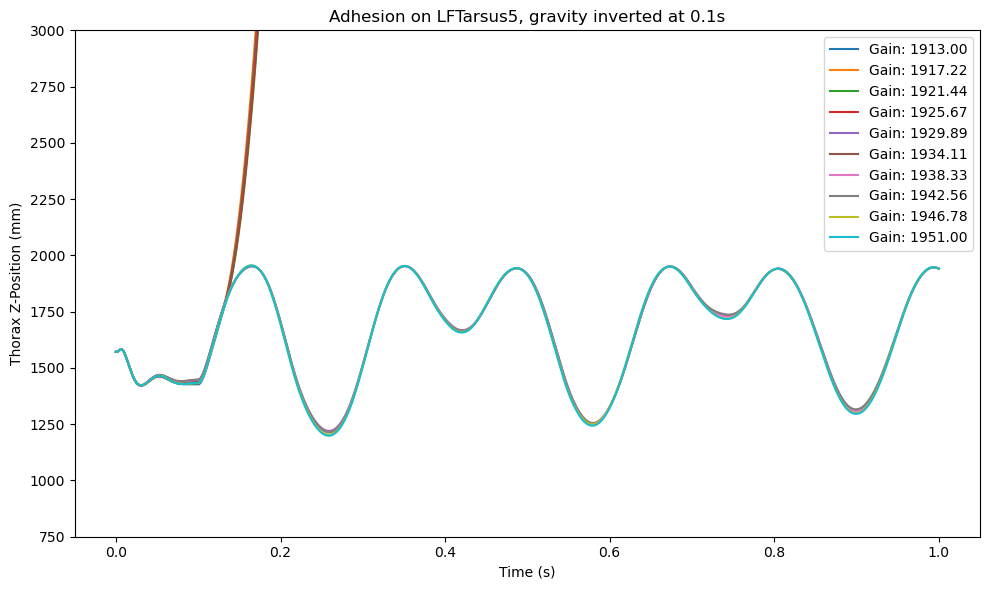

<Figure size 640x480 with 0 Axes>

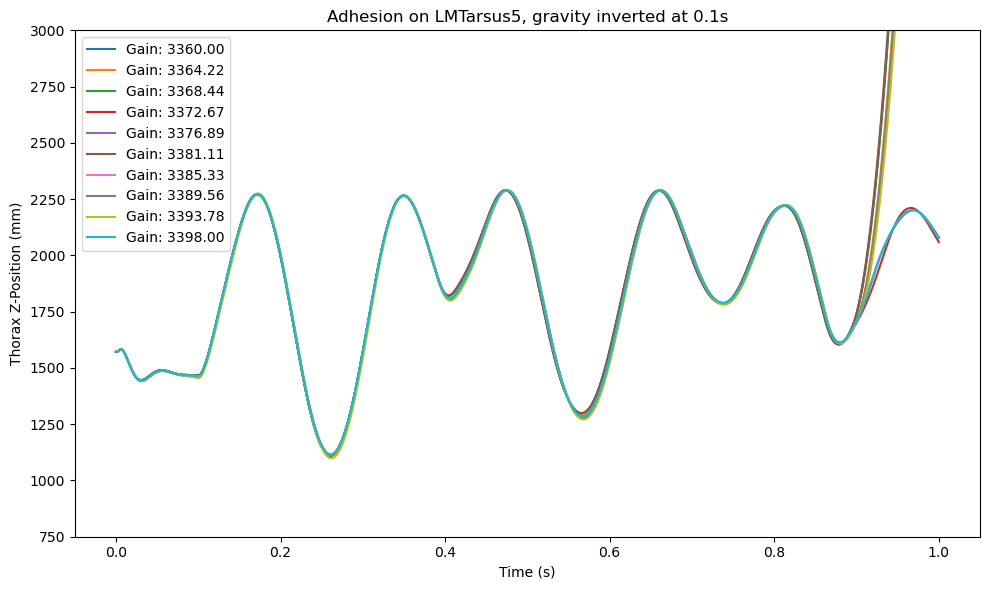

<Figure size 640x480 with 0 Axes>

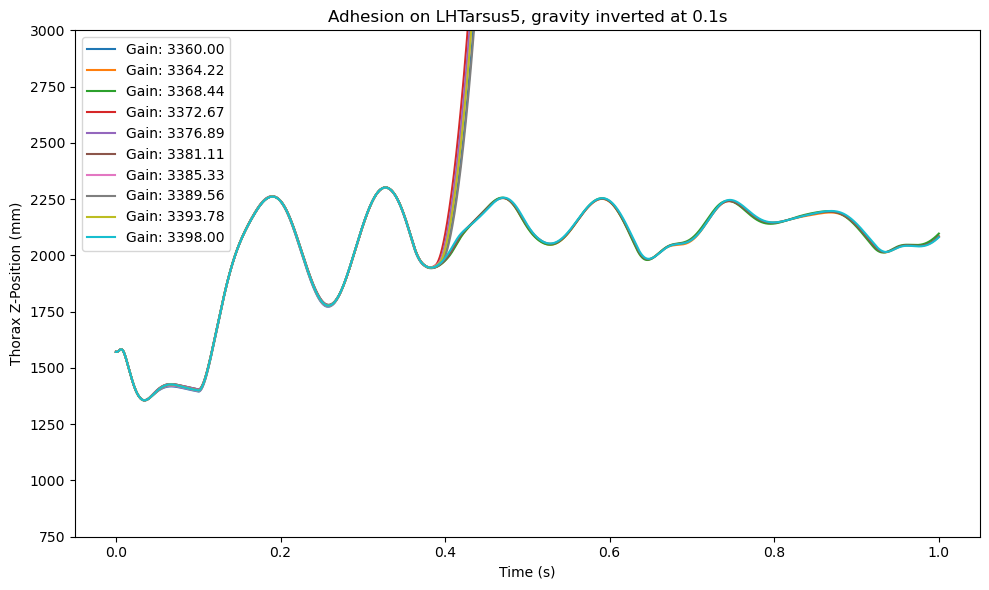

<Figure size 640x480 with 0 Axes>

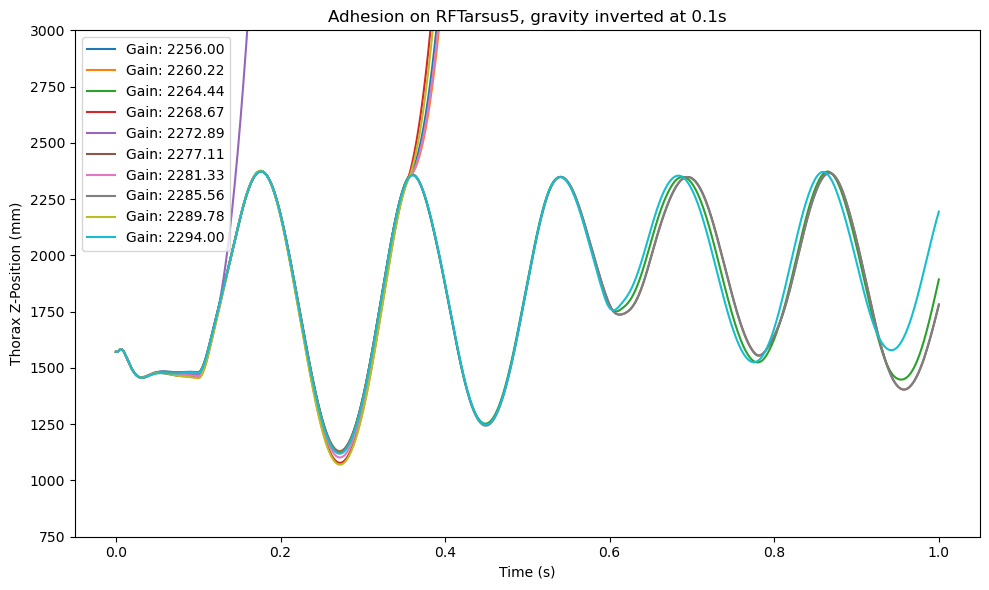

<Figure size 640x480 with 0 Axes>

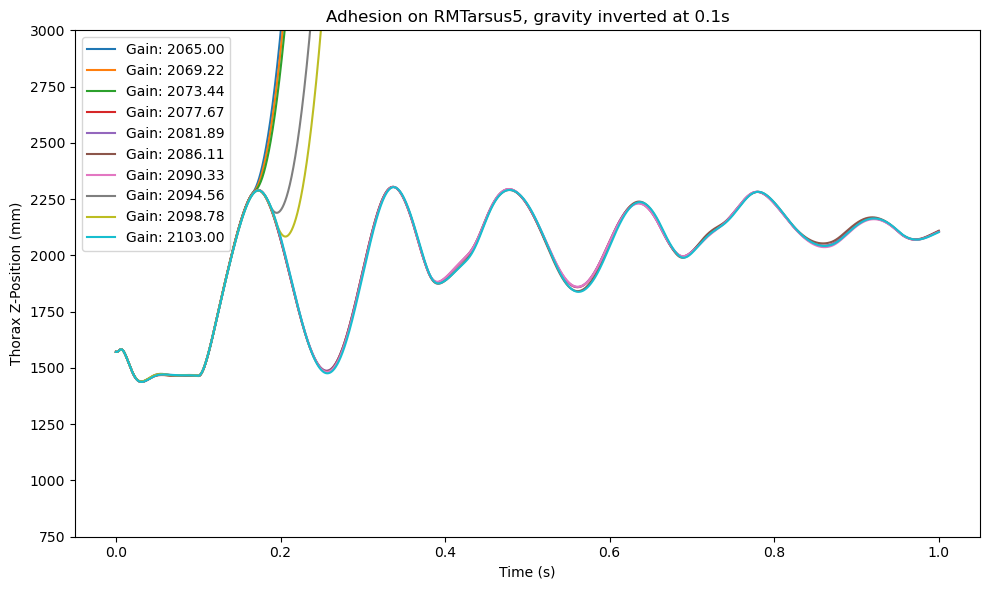

<Figure size 640x480 with 0 Axes>

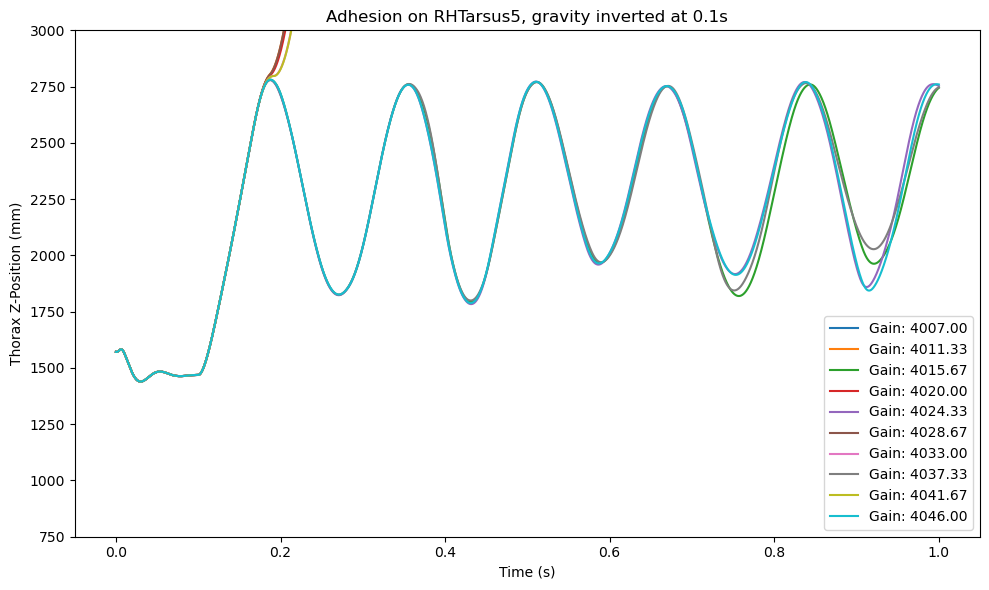

<Figure size 640x480 with 0 Axes>

In [22]:
for i, leg_idx in enumerate(legs): 
    plot_z_vals(z_vals_list[i], nmfs_list[i], found_ranges[i], leg_idx=legs.index(leg_idx))

Critical Gain: 1930 
Range: [1913,1951]
Critical Gain: 3373 
Range: [3360,3398]
Critical Gain: 3364 
Range: [3360,3398]
Critical Gain: 2264 
Range: [2256,2294]
Critical Gain: 2078 
Range: [2065,2103]
Critical Gain: 4016 
Range: [4007,4046]


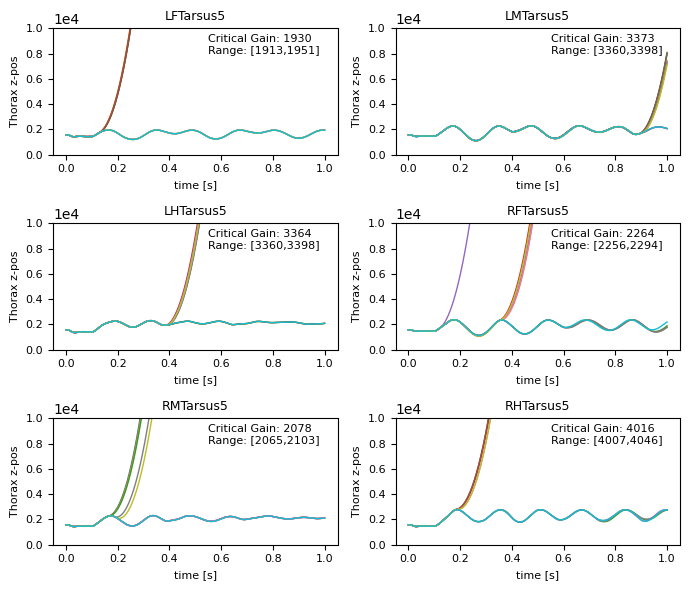

<Figure size 640x480 with 0 Axes>

In [23]:
def plot_all_legs_zvals(z_vals_list, nmfs_list, found_ranges, did_it_stick_ranges):
    fig1 = plt.figure(figsize=(7,6))
    for i in np.arange(6):
        ax1 = fig1.add_subplot(321 + i)
        text1 = f'Critical Gain: {found_ranges[i][np.argmax(did_it_stick_ranges[i])]:.0f} \nRange: [{int(found_ranges[i][0])},{int(found_ranges[i][-1])}]'
        ax1.text(0.55, 8000,text1, fontsize = 8)
        print(text1)
        #text2 = f'Range: [{found_ranges[i][0]:.1f},{found_ranges[i][-1]:.0f}]'
        #ax1.text(0.6, 5000,text2)

        for gain, z_val, nmf in zip(found_ranges[i], z_vals_list[i], nmfs_list[i]):
            ax1.plot(np.arange(len(z_val))*nmf.timestep, z_val, label=f'Gain: {gain:.2f}', linewidth = 1)
        ax1.set_ylim(0,10000)
        ax1.set_xlabel('time [s]', fontsize = 8)
        ax1.set_ylabel('Thorax z-pos', fontsize = 8)
        ax1.tick_params(labelsize=8)
        ax1.ticklabel_format(style ='sci', axis='y', scilimits=(0,0))
        ax1.set_title(legs[i], fontsize = 9)
    save_path = Path('notebooks/SingleLegFigures',f'Adhesion_on_all_legs_gravity_inverted_at_01s.png')
    plt.tight_layout()
    fig1 = plt.gcf() 
    plt.show()
    plt.draw()
    fig1.savefig(save_path)

plot_all_legs_zvals(z_vals_list, nmfs_list, found_ranges, did_it_stick_ranges)

# CHANGE PATH TO INCLUDE /notebooks


In [ ]:
from ipywidgets import Video
#legs = ['LFTarsus5', 'LMTarsus5']
#found_ranges = [[1000,2000, 2300], [3000, 3400, 3500]]
#did_it_stick_ranges = [[False, True, True], [False, True, True]]
min_gains = []

for leg_idx, gain_range, did_it_stick in zip(np.arange(len(legs)), found_ranges, did_it_stick_ranges):
    print(leg_idx)

    gain_range = np.array(gain_range)
    did_it_stick = np.array(did_it_stick)
    gain = gain_range[did_it_stick][0]
    min_gains.append(gain)
    print(gain)
    nmf, thorax_z_vals = run_grid(gain, adhesion_array = np.where(leg_idx == np.arange(6), 1, 0), render_mode="saved", render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'})
    #video_path = Path('SingleLegFigures', f'Adhesion on {legs[leg_idx]}: gain = {gain}, gravity inverted at 0.1s.mp4')
    video_path = Path('SingleLegFigures',f'Adhesion_on_{legs[leg_idx]}_gain_{gain}_gravity_inverted_at_01s.mp4')

    nmf.save_video(video_path)
    #Video.from_file(video_path)

for leg_idx in enumerate(legs):
    Path('SingleLegFigures',f'Adhesion_on_{legs[leg_idx]}_gain_{min_gains[leg_idx]}_gravity_inverted_at_01s.mp4')
    Video.from_file(video_path)



0
1929.888888888889
[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="1929.8888888888889"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="1929.8888888888889"/>] actuators _adhesion


# Junk / Outdated

In [ ]:
nmfs = []
z_vals = []
for gain in gain_grid: 
    print(gain)
    nmf, thorax_z_vals = run_grid(gain, adhesion_array = np.array([0,0,1,0,0,0]))    
    nmfs.append(nmf)
    z_vals.append(thorax_z_vals)
print(nmfs[0].actuated_adhesion_bodies)

In [ ]:
nmfs = []
z_vals = []
for gain in gain_grid: 
    print(gain)
    nmf, thorax_z_vals = run_grid(gain, adhesion_array = np.array([0,0,1,0,0,0]))    
    nmfs.append(nmf)
    z_vals.append(thorax_z_vals)
print(nmfs[0].actuated_adhesion_bodies)


2000.0
[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2000"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:28<00:00, 351.86it/s]


4000.0
[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>] actuators _adhesion


100%|██████████| 10000/10000 [00:25<00:00, 394.43it/s]

['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']


In [ ]:
len(z_vals)

2

In [ ]:
z_vals

[[1571.4261708778677,
  1571.3081118103944,
  1571.1920839881398,
  1571.0994662709466,
  1571.0332100050762,
  1570.9920143478682,
  1570.9733814938147,
  1570.9745673771065,
  1570.992985015182,
  1571.0264049185935,
  1571.0730492313617,
  1571.1316130581793,
  1571.2012281394277,
  1571.281408852523,
  1571.3719807118187,
  1571.4730082039225,
  1571.5847309921323,
  1571.70751156069,
  1571.841792547967,
  1571.9880869542483,
  1572.1468763897221,
  1572.3186431710242,
  1572.5038287009995,
  1572.7028033733063,
  1572.9157885410352,
  1573.1429686153963,
  1573.384348949751,
  1573.6397669488774,
  1573.908883799896,
  1574.1911803186001,
  1574.4859564722442,
  1574.7923361503467,
  1575.1092834252913,
  1575.4356183841783,
  1575.7700356014907,
  1576.1111241671977,
  1576.457388352139,
  1576.8072681774784,
  1577.1591496505791,
  1577.5114062761581,
  1577.8624022939573,
  1578.2105093900764,
  1578.5541220082437,
  1578.891671013451,
  1579.221635863537,
  1579.542563773569,

Text(0, 0.5, 'thorax z-value')

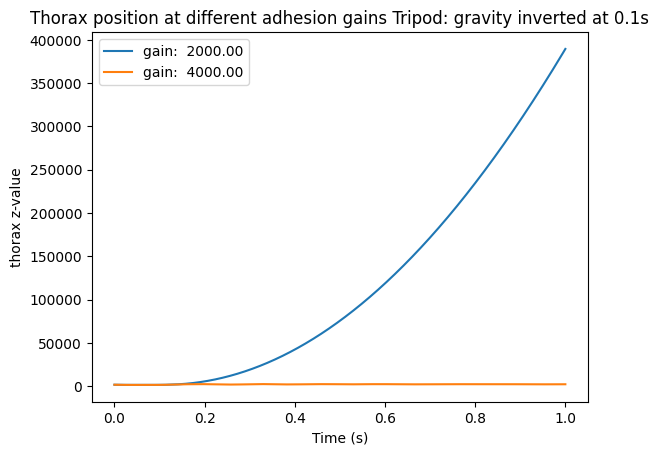

In [ ]:
for i, gain in enumerate(gain_grid):
        plt.plot(np.arange(len(z_vals[i])) * nmf.timestep,
                z_vals[i],
                label=f'gain: {gain: .2f}')
plt.title('Thorax position at different adhesion gains Tripod: gravity inverted at 0.1s')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('thorax z-value')
#plt.ylim(750,3000)

In [ ]:
gain_grid[5]

1942.7272727272727

We will fix the maximum necessary gain LFTarsus to 1942.73!